In [2]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from vis_common import load_store, load_games

FS = (10, 6) # Reasonable default figsize
DECILES = list(np.arange(0.1, 1.0, 0.1))

store = load_store()
g = games = load_games()

In this post, I'll be taking a step back and doing some analysis at the level of players of DCSS, rathern than individual games. How many players do we have?

In [2]:
print "{:,} distinct players among {:,} games".format(
    g['pid'].unique().shape[0], len(g)
)
print "Distribution of games played per player..."
g.groupby('pid').size().describe()

26,004 distinct players among 1,326,162 games
Distribution of games played per player...


count    26004.000000
mean        50.998385
std        201.641369
min          1.000000
25%          1.000000
50%          3.000000
75%         20.000000
max       8170.000000
dtype: float64

The "average" player has 50 games, though this statistic is pretty misleading. A majority of players can count their games on one hand. 

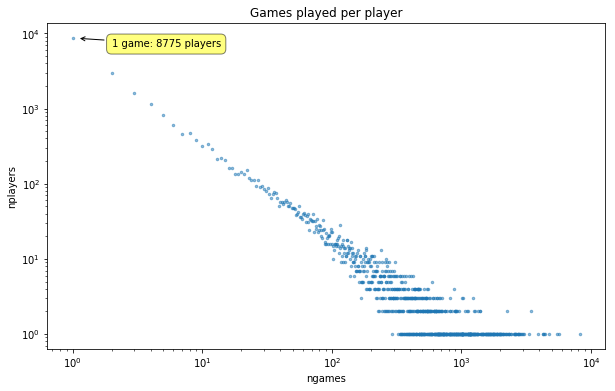

In [5]:
count_counts = g.groupby('pid').size().value_counts().to_frame('nplayers')
count_counts['ngames'] = count_counts.index
fig, ax = plt.subplots(figsize=FS)
ax.scatter(count_counts['ngames'], count_counts['nplayers'], marker='.', s=25, alpha=.5)
onegame = count_counts.loc[1]['nplayers']
ax.annotate("1 game: {} players".format(onegame), 
            xy=(1.1, onegame*.98), xytext=(2, onegame*.75),
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
           )
ax.set_xlabel('ngames')
ax.set_ylabel('nplayers')
ax.set_title("Games played per player")
ax.loglog();

A straight line on a log-log plot. Looks like some kind of power-law distribution. 

51.4% of players have <= 3 games


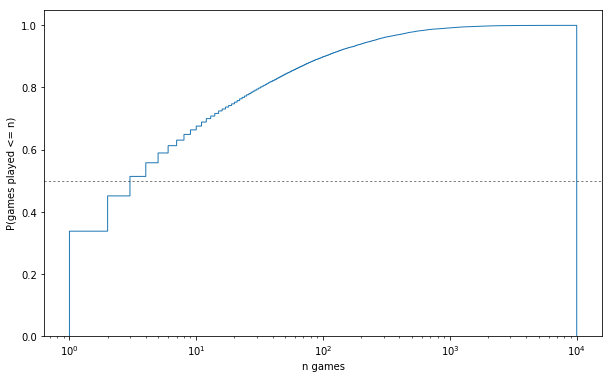

In [10]:
fig, ax = plt.subplots(figsize=FS)
counts = g.groupby('pid').size().values
n, bins, patches = ax.hist(counts, 
                           np.arange(1, 10**4),
                           #np.logspace(0, 4, 150),
       normed=1, histtype='step', cumulative=1
)
midpoint = (n >= .5).argmax()
midpct = 100 * n[midpoint]
ax.set_xscale('log');
ax.axhline(y=.5, color='black', linestyle=':', linewidth=.5);
ax.set_xlabel('n games')
ax.set_ylabel('P(games played <= n)');
print '{:.1f}% of players have <= {} games'.format(
    midpct, midpoint+1)

What about the distribution of wins across players?

In [11]:
gpp = games_per_pid = g.groupby('pid').size()
wpp = wins_per_pid = g.groupby('pid')['won'].sum()
wpp = wins_per_pid
print "{:,} / {:,} players have won at least one game".format(
    (wpp > 0).sum(), len(wpp)
)

2,111 / 26,004 players have won at least one game


That statistic certainly speaks to DCSS's difficulty. 

**>90%** of players have a 0% win rate.

In [6]:
print "Do winners account for more games?"
winpids = wpp.where(lambda wins: wins > 0).dropna().index
print "Avg. number of games played by...\n\twinners: {:.1f}\n\tnon-winners: {:.1f}".format(
    g[g['pid'].isin(winpids)].groupby('pid').size().mean(),
    g[~g['pid'].isin(winpids)].groupby('pid').size().mean(),
)
winnergames = g['pid'].isin(winpids).sum()
print "{:,} out of {:,} games ({:.1f}%) were played by players who have won a game".format(
    winnergames, len(g), 100*winnergames/len(g),
)

Do winners account for more games?
Avg. number of games played by...
	winners: 305.3
	non-winners: 28.5
644,434 out of 1,326,162 games (48.6%) were played by players who have won a game


In [12]:
gameticks = [1, 2, 5, 10, 25, 50, 100, 250, 
                          500, 1000, 2000, 4000,
                          10000]
winticks = [1, 2, 5, 10, 25, 50, 100]
def scatter_games_v_wins(minwins=0, jitter=False):
    fig, ax = plt.subplots(figsize=FS)
    wins = wpp[wpp >= minwins]
    winjitter = 0
    if jitter:
        winjitter = (np.random.rand(len(wins)) - .5) * .55
    ax.scatter(gpp.loc[wins.index], wins.values + winjitter,
              alpha=.1,
              )
    ax.set_yscale('symlog' if minwins==0 else 'log')
    ax.set_xscale('log')
    ax.set_xticks(gameticks)
    ax.set_yticks(winticks);
    ax.set_xticklabels([str(i) for i in gameticks])
    ax.set_yticklabels([str(i) for i in winticks]);
    ax.set_xlabel('Games')
    ax.set_ylabel('Wins')
    ax.set_title("Games vs. wins per player")
    return ax

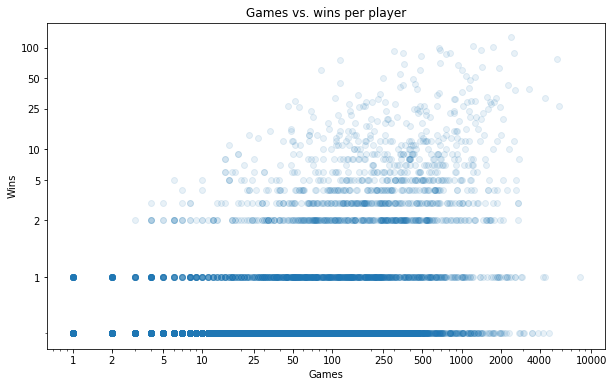

In [13]:
scatter_games_v_wins();

Here I'm placing a dot for each player, according to their number of games played and number of wins (still on a log-log scale). It's hard to get a sense of what's going on in those stripes that form at 0/1/2 wins. We can maybe get a better sense of the density by randomly jittering each point in the y direction:

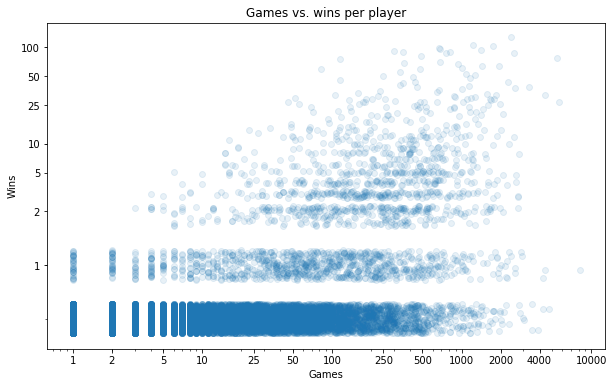

In [14]:
scatter_games_v_wins(jitter=1);

We already knew there were a *lot* of players with 0 wins (more than 90% of all players). But it's interesting to see that this isn't just a result of having lots of players who have played a tiny number of games. There are lots of players who have played 100+ games without a win.

Let's turn our attention to just the players with at least 1 win.

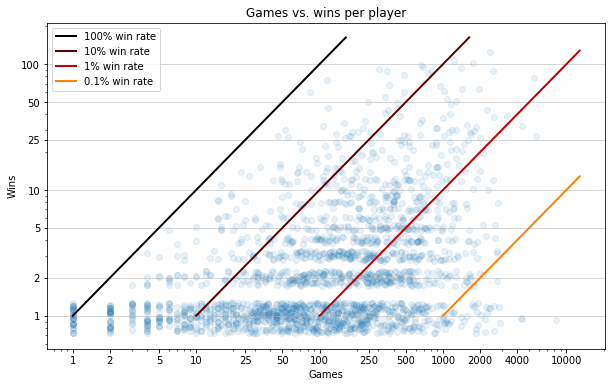

In [23]:
ax = scatter_games_v_wins(minwins=1, jitter=1)
ax.grid(axis='y', lw=.5);
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ymin = 1
cmap = plt.get_cmap('gist_heat')
winrate_lines = [.001, .01, .1, 1.0]
for i, wr in enumerate(reversed(winrate_lines)):
    p1 = [ymin/wr, ymin]
    if xmax*wr <= ymax:
        p2 = [xmax, xmax*wr]
    else:
        p2 = [ymax/wr, ymax]
    xs, ys = zip(p1, p2)
    ax.plot(xs,
            ys,
            label=('{}% win rate'.format(int(wr*100)) if wr >= .01
                   else '{:.1f}% win rate'.format(wr*100)),
            color=cmap(i/len(winrate_lines)),
            linewidth=2, linestyle='-',
    )
ax.legend();

Eyeballing the diagonal guides, it seems like the greatest density is around the 1% win rate, with the vast majority falling somewhere between 0.1 and 10%.

There appear to be a fair number of players with a 100% win rate over 1 game.

In [21]:
perfect = gpp == wpp
print "{} players have a perfect record (avg. number of games played = {})".format(
    perfect.sum(), gpp[perfect].mean(),
)

37 players have a perfect record (avg. number of games played = 1.0)


Far more impressive are those few dots with a >50% win rate over 50+ games.

In [30]:
wrpp = g[g['pid'].isin(gpp[gpp >= 50].index)].groupby('pid')['won'].mean().rename('winrate')
tops = wrpp.sort_values(ascending=0).head(3)
players = store['players']
pd.concat([tops, players.loc[tops.index].rename('name')], axis=1)

,winrate,name
pid,,
17003,0.722892,jumbajumba
6203,0.652174,makemeasandwich
8250,0.576923,hellmonk



## Separating the wheat from the chaff

It'd be really useful if we could assign a score to each player that reflected how good they are at the game.

### Motivation

Let's say we have some hypothesis about some gameplay decision, like...

- Abyssal is usually a safer third rune than Silver
- Axes are better than maces for Minotaur Fighters
- The best use of scrolls of acquirement is to acquire food

One simple way to evaluate these kinds of claims is by looking at the games where $choice occurred (e.g. the games where the player went for abyssal as their third rune, or MiFi games where the player focused on axes), and seeing how many of them ended in victory, compared to games where the alternative occurred. 

The problem with this approach is that it uses a signal which is sparse and noisy.

1. **Sparse** because DCSS is a hard game. Out of over a million games, my dataset has less than 10,000 wins. If, say, 10 games out of 1,000 were won when decision A happened, and 15 games out of 1,000 were won with decision B, we can't really say B is better with much confidence, because there's a lot of variance when dealing with such small win rates.
2. **Noisy** because games involve a lot of decisions (and randomness). The effect of any one decision on whether that game is won is going to be pretty small. 

In some cases, we might find it easier to **just ask what skilled players do**. "How often do strong players take the Abyssal rune as their third?" "Do strong players specialize in axes more often than maces when playing MiFis?"

By assigning a varied range of 'skill' scores to players, we no longer have the problem of sparsity. Even if games A and B were both lost, we can say that A was 'better' if it was played by a player with a 5% win rate, and B was played by someone with a 0.5% win rate.

This should also be a less noisy signal. The effect of any given decision on whether a game is won may be very inconsistent, but we can expect players to be pretty consistent in their decision-making. 

The downside is that we're measuring the goodness of these choices indirectly, relying on the assumption that good players make good decisions. If the competitive community agreed on some common wisdom that turned out to be counterproductive, this approach would fail to identify it as such.

(Also, knowing whether a particular behaviour is strongly associated with experienced/inexperienced players is interesting in its own right, even if we're not trying to make any claims about a causal effect on winning.)

### Sorting by win rate

The simplest metric would just be the raw win rate per player: `nwins / ngames`.

In [42]:
print "Distribution of win rates (as %) across players"
wrpp = g.groupby('pid')['won'].mean().rename('winrate')
(100*wrpp).describe([.5, .9, .925, .95, .975, .99, .995])

Distribution of win rates (as %) across players


count    26004.000000
mean         0.605308
std          5.030780
min          0.000000
50%          0.000000
90%          0.000000
92.5%        0.236466
95%          1.265480
97.5%        4.166125
99%         14.574405
99.5%       31.988750
max        100.000000
Name: winrate, dtype: float64

This is still a pretty sparse signal - over 90% of players get assigned the same score of 0.

Intuitively, it seems like there should be room for differentiation among those non-winners. Player A, with 0 wins out of 300 games should probably be ranked lower than B with 0 wins out of 2 games. We have pretty strong evidence that A has a low winrate. But B's record is not at all inconsistent with them having, say, a 10% winrate.

Similarly, a player with 30 wins out of 100 games should probably rank higher than a player with 1 win out of 1 game, even though the latter has a much higher nominal win rate. As it is, once our winrates are non-zero, they shoot up exponentially through the last 7.5%. The players with one or two wins out of a small number of games are inflating the top end.

This is basically the same problem as [sorting starred product reviews](http://www.evanmiller.org/how-not-to-sort-by-average-rating.html). The bread machine with a single 5-star review should probably not be ranked higher than the one with 100 reviews averaging 4.9 stars.

### Getting Bayesian

We're trying to estimate the "true" win rate `wr` (i.e. the value that player's win rate would converge on if we sat them down and made them play DCSS for eternity), given the evidence that they've won `w` out of `n` games.

Bayes' rule for conditional probabilities gives the expression

$$P(wr \mid w,n) = \frac{P(w,n \mid wr) \cdot P(wr)} {P(w,n)}$$

We want to find the most probable win rate, i.e. the one that maximizes this expression. Our choice of `wr` has no effect on `P(w,n)`, the probability of the observed number of wins and games, so we can drop that term, leaving us to maximize:

$$P(wr \mid w,n) \propto P(w,n \mid wr) \cdot P(wr)$$

If we say that all win rates are equally likely, we can also drop `P(wr)`. Choosing `wr` that maximizes `P(w,n | wr)` is easy. It's just `w/n`. For example, the coin that is most likely to produce 4 heads out of 5 flips is the one with `P(heads) = .8`.

But now we're back where we started. Where did we go wrong?

### Incorporating prior knowledge

Are all win rates equally likely? Of course not. For example, we know that, among players with a non-trivial number of games, win rates above 10% are exceedingly rare. 

If we knew that most coins were fair, we should probably just guess that our coin has `P(heads) = .5` even after seeing 4 heads out of 5 flips.

Let's add a couple parameters to our earlier expression:

$$P(wr \mid w,n,\pi,C) \propto P(w,n \mid wr) \cdot P(wr \mid \pi,C)$$

$\pi$ and $C$ are parameters describing our prior beliefs about where winrates fall. $\pi$ represents a typical win rate, and $C$ is a scaling factor that controls the strength of our prior belief.

I won't go through the derivation here (check out [this wiki article](https://en.wikipedia.org/wiki/Conjugate_prior#Example) if you're interested), but it turns out the winrate that maximizes this is just:

$$ \frac{C \pi + w} {C + n} $$

### Choosing a prior

A simple way to think about this transformation is that we're padding our calculated win rate with $C$ additional games, of which $C \pi$ are wins.

An obvious value for $\pi$ is just the win rate over all games in the dataset (0.74%).

$C$ is a bit more arbitrary, but let's start at 10 and see how that works out.

(Note on more complex priors)

**TODO**: maybe C should be higher? the strength of 1 win out of 1 makes me a lil nervous.

In [7]:
wr_prior = g['won'].mean()
# Controls the strength of the smoothing
C = 10
def smooth(wins, games):
    return 100 * (
        (wins + (C * wr_prior))
        /
        (C + games)
    )

wg = [
    (0, 1), (1, 1), (0, 10), (0, 50), (1, 500), (1, 10), (5, 50), (20, 200),
]
for (wi, ga) in wg:
    print "{} wins / {} games: {:.2f}%".format(wi, ga, smooth(wi, ga))

0 wins / 1 games: 0.67%
1 wins / 1 games: 9.76%
0 wins / 10 games: 0.37%
0 wins / 50 games: 0.12%
1 wins / 500 games: 0.21%
1 wins / 10 games: 5.37%
5 wins / 50 games: 8.46%
20 wins / 200 games: 9.56%


In [16]:
import winrate
g['raw winrate'] = g.groupby('pid')['won'].mean().loc[g['pid']].values
g['wr'] = winrate.smoothed_winrate(g)
(100*g[['raw winrate', 'wr']]).rename(columns={'wr': 'smoothed winrate'})\
    .describe([.1, .25, .5, .75, .9, .95])

,raw winrate,smoothed winrate
count,1.326162e+06,1.326162e+06
mean,7.393516e-01,7.398727e-01
std,2.514039e+00,2.132121e+00
min,0.000000e+00,1.564103e-03
10%,0.000000e+00,8.940164e-03
25%,0.000000e+00,2.718204e-02
50%,0.000000e+00,1.320271e-01
75%,5.464481e-01,5.870224e-01
90%,1.743836e+00,1.727191e+00
95%,3.396226e+00,3.222991e+00


This looks pretty good. There's a lot of variation now in the lower half - the median is an order of magnitude above the first decile. And the top end has been dampened (the highest smoothed winrate is 65%, compared to 100% in the unsmoothed version).